# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [99]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


Constants

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-smote-simple"
REMARK = "Try current best model with more relevant pricing"
BATCH_SIZE = 2024
LEARNING_RATE = 1e-5
EPOCH = 200
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanAbsoluteError()

Log dir

In [ ]:
stopper

In [101]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


FileExistsError: 

## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [ ]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_better_price_and_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [ ]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
0,1723,6018900,8078640,15046770,"Category 8,Category 2",9.37,0,0,1,1,1
1,82,23809950,35177250,44279670,"Category 4,Category 2,Category 1,Category 8,Ca...",9.26,0,0,1,1,1
2,296,3427860,5198670,5264340,"Category 6,Category 1,Category 4,Category 5",9.25,0,0,1,1,0
3,127,20207160,38229630,74752350,"Category 7,Category 6",9.17,0,0,1,1,1
4,137,4537980,8215080,13298910,"Category 6,Category 1,Category 4,Category 5",9.16,0,0,1,1,1


In [ ]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6406 non-null   int64  
 1   insta_follower     6406 non-null   int64  
 2   tiktok             6406 non-null   int64  
 3   youtube            6406 non-null   int64  
 4   categories         6406 non-null   object 
 5   avg_rating         6406 non-null   float64
 6   pricing_LOW        6406 non-null   int64  
 7   pricing_BELOW_AVG  6406 non-null   int64  
 8   pricing_AVG        6406 non-null   int64  
 9   pricing_ABOVE_AVG  6406 non-null   int64  
 10  pricing_HIGH       6406 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 550.6+ KB


In [ ]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
count,6406.000000,6.406000e+03,6.406000e+03,6.406000e+03,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000
mean,3505.326881,9.936103e+05,1.405106e+06,1.952503e+06,6.954530,0.625976,0.716984,0.230097,0.089291,0.063534
std,2153.761090,2.158019e+06,3.200647e+06,4.601825e+06,0.804705,0.483908,0.450499,0.420927,0.285186,0.243940
min,1.000000,1.290000e+03,1.260000e+03,2.490000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1607.250000,6.016500e+04,8.160750e+04,1.084950e+05,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3312.500000,2.187150e+05,2.956500e+05,4.113000e+05,7.010000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5384.750000,8.947575e+05,1.201725e+06,1.692038e+06,7.470000,1.000000,1.000000,0.000000,0.000000,0.000000
max,7387.000000,3.041751e+07,4.039176e+07,7.475235e+07,9.370000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80


In [ ]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413446 entries, 0 to 413445
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            413446 non-null  int64  
 1   inf_id            413446 non-null  int64  
 2   star_rating       413446 non-null  int64  
 3   sentiment_rating  413446 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.6 MB


In [ ]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,413446.000000,413446.000000,413446.000000,413446.000000
mean,2443.219533,1076.748458,4.141170,0.777486
std,1438.596784,1148.850785,0.789503,0.161847
min,1.000000,1.000000,1.000000,0.000000
25%,1214.000000,260.000000,4.000000,0.680000
50%,2456.000000,639.000000,4.000000,0.790000
75%,3699.000000,1532.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [ ]:
df_influencer.isnull().sum()

id                   0
insta_follower       0
tiktok               0
youtube              0
categories           0
avg_rating           0
pricing_LOW          0
pricing_BELOW_AVG    0
pricing_AVG          0
pricing_ABOVE_AVG    0
pricing_HIGH         0
dtype: int64

In [ ]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [ ]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [ ]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [ ]:
YOUTUBE_HIGH_THRES = 2_000_000
YOUTUBE_LOW_THRES = 100_000
TIKTOK_HIGH_THRES = 2_000_000
TIKTOK_LOW_THRES = 100_000
INSTAGRAM_HIGH_THRES = 1_000_000
INSTAGRAM_LOW_THRES = 50_000

# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = df_inf_norm[['avg_rating']] / 10
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

# df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

youtube_bin = [0, YOUTUBE_LOW_THRES, YOUTUBE_HIGH_THRES, df_inf_norm['youtube'].max()]
tiktok_bin = [0, TIKTOK_LOW_THRES, TIKTOK_HIGH_THRES, df_inf_norm['tiktok'].max()]
insta_bin = [0, INSTAGRAM_LOW_THRES, INSTAGRAM_HIGH_THRES, df_inf_norm['insta_follower'].max()]

df_inf_norm['youtube'] = pd.cut(df_inf_norm['youtube'],bins=youtube_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'youtube') 

df_inf_norm['tiktok'] = pd.cut(df_inf_norm['tiktok'],bins=tiktok_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 

df_inf_norm['insta_follower'] = pd.cut(df_inf_norm['insta_follower'],bins=insta_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1723,0.937,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,82,0.926,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.925,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.917,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.916,0,0,1,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [ ]:
STAR_WEIGHT = 0.5
SENTIMENT_WEIGHT = 0.5

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.77,0.785
1,1,3,3,0.53,0.565
2,1,5,5,0.89,0.945
3,1,6,5,0.90,0.950
4,1,7,4,0.80,0.800
...,...,...,...,...,...
413441,4999,49,5,0.90,0.950
413442,4999,670,5,0.84,0.920
413443,4999,62,5,0.92,0.960
413444,4999,770,5,0.93,0.965


In [ ]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2768,2768,2768,2768
2,9217,9217,9217,9217
3,59531,59531,59531,59531
4,197295,197295,197295,197295
5,144635,144635,144635,144635


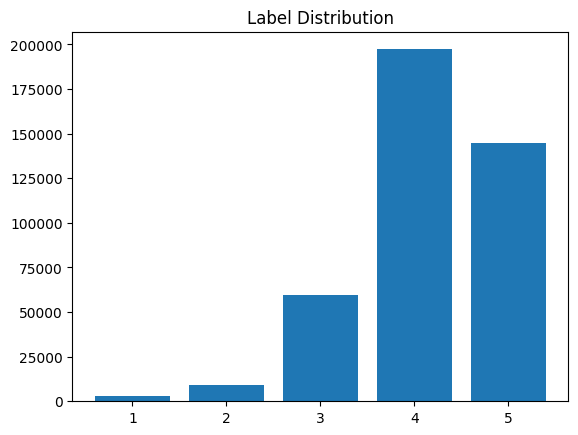

In [ ]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [ ]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,1,0.785,1,0.735,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.565,3,0.685,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.945,5,0.754,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,0.950,6,0.871,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
4,1,7,0.800,7,0.830,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,0.000000,0.00000,0.821250,0.632500,0.632500,0.296875,0.000000,0.631875,0.000000,...,0.000000,0.821250,0.0,0.000000,0.821250,0.0,0.000000,0.821250,0.0,0.000000
1,2,0.036617,0.07491,0.753428,0.503832,0.428503,0.422844,0.001737,0.500150,0.114371,...,0.017784,0.742545,0.0,0.131033,0.686916,0.0,0.186662,0.749042,0.0,0.124536
2,3,0.000000,0.00000,0.828676,0.615441,0.560294,0.381029,0.000000,0.476618,0.000000,...,0.000000,0.793088,0.0,0.088824,0.776029,0.0,0.105882,0.881912,0.0,0.000000
3,4,0.000000,0.00000,0.825732,0.772927,0.713902,0.684268,0.019146,0.412439,0.038049,...,0.000000,0.825732,0.0,0.000000,0.807439,0.0,0.018293,0.825732,0.0,0.000000
4,5,0.000000,0.01736,0.782079,0.651404,0.541629,0.288876,0.006910,0.501236,0.168371,...,0.051292,0.767303,0.0,0.045225,0.767303,0.0,0.045225,0.795169,0.0,0.017360


##### Process feature and label

Influencer features

In [ ]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.785,0.735,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.565,0.685,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.945,0.754,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.950,0.871,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.800,0.830,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [ ]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history.drop(["star_rating", "sentiment_rating"], axis=1), df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,1,0.785,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,1,3,0.565,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,1,5,0.945,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,1,6,0.950,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,1,7,0.800,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0


In [ ]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.785,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,0.565,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,0.945,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,0.950,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,0.800,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0


In [ ]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [ ]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.785
1    0.565
2    0.945
3    0.950
4    0.800
Name: combined_rating, dtype: float64

##### Oversampling

In [ ]:
df_inf_features = df_inf_features.drop(["combined_rating"], axis=1)
df_own_features = df_own_features.drop(["combined_rating"], axis=1)
df_own_features

,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,Category 4,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413441,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413442,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413443,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413444,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0


In [ ]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import random

# Apply oversampling to each input type separately
smote = SMOTE()
df_features = pd.concat([df_inf_features, df_own_features], axis=1)
df_features, star_ratings = smote.fit_resample(df_features, df_history['star_rating'].values)

In [ ]:
rating_count = np.unique(star_ratings, return_counts=True) 
rating_count

(array([1, 2, 3, 4, 5], dtype=int64),
 array([197295, 197295, 197295, 197295, 197295], dtype=int64))

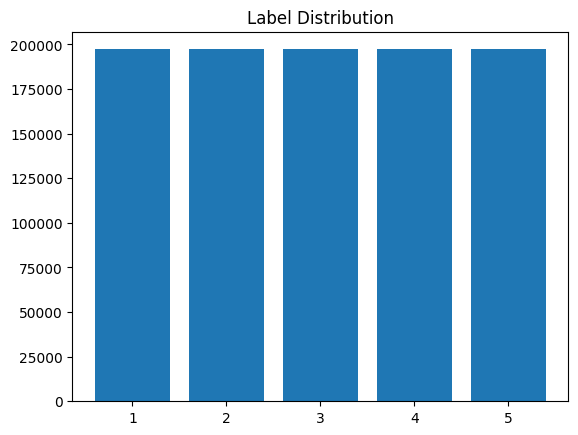

In [ ]:
# Chart labels
rating_count = rating_count[1]
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

In [ ]:
star_ratings = star_ratings / 5
sentiment_ratings = star_ratings - 0.1 + 0.2 * random.random()
df_labels = pd.Series((STAR_WEIGHT * star_ratings + SENTIMENT_WEIGHT * sentiment_ratings).clip(0, 1))

In [ ]:
df_data = pd.concat([df_features, df_labels], axis=1).sample(frac=1)

In [ ]:
df_inf_features = df_data.iloc[:, :INFLUENCER_FEATURE_COUNT]
df_own_features = df_data.iloc[:, INFLUENCER_FEATURE_COUNT:-1]
df_labels = df_data.iloc[:, -1]

##### Generate train, validation, and test dataset

In [ ]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(25,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [ ]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.95)
VAL_SIZE = int(DATASET_SIZE * 0.025)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 937151 data
Validation dataset has 24661 data
Testing dataset has 24663 data


In [ ]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

##### Check Distribution

In [ ]:
def get_label(dataset):
    labels = np.array([])
    for batch in dataset:
        labels = np.concatenate([labels, batch[1].numpy()])

    return labels

In [ ]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(train_dataset), bin)
np.unique(bucket, return_counts=True)

(array([2, 3, 4, 5, 6], dtype=int64),
 array([187481, 187356, 187383, 187384, 187547], dtype=int64))

In [ ]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(val_dataset), bin)
np.unique(bucket, return_counts=True)

(array([2, 3, 4, 5, 6], dtype=int64),
 array([4876, 4968, 4983, 5000, 4834], dtype=int64))

In [ ]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(test_dataset), bin)
np.unique(bucket, return_counts=True)

(array([2, 3, 4, 5, 6], dtype=int64),
 array([4943, 4974, 4904, 4927, 4915], dtype=int64))

## Creating Model

Model consists of two neural networks that would be combined with Dot layer. The first neural network has influencer features as input and a vector as an output. The second one has owner features as input and a vector as an output. These two vectors will be combined with Dot layer and produces a single combined rating

In [ ]:
VECTOR_SIZE = 64
# tf.random.set_seed(1)

model_influencer = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    # tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the influencer input and point to the base network
input_influencer = tf.keras.layers.Input(shape=(INFLUENCER_FEATURE_COUNT), name="inf_feature")
vi = model_influencer(input_influencer)
vi = tf.linalg.l2_normalize(vi, axis=1)

model_owner = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    # tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the owner input and point to the base network
input_owner = tf.keras.layers.Input(shape=(OWNER_FEATURE_COUNT), name="own_feature")
vo = model_owner(input_owner)
vo = tf.linalg.l2_normalize(vo, axis=1)

# compute the dot product of the two vectors vi and vo
output = tf.keras.layers.Dot(axes=1)([vi, vo])

# specify the inputs and output of the model
model = tf.keras.Model([input_influencer, input_owner], output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 24)]         0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           23104       ['inf_feature[0][0]']            
                                                                                                  
 sequential_3 (Sequential)      (None, 64)           22848       ['own_feature[0][0]']            
                                                                                            

In [ ]:
import time

start_time = time.time()
model.compile(optimizer= OPTIMIZER, 
              loss=LOSS_FN,
              metrics=["mse", "mae"])

model = tf.keras.models.load_model(os.path.join(KERAS_DIR, LOG_NAME))
LOG_NAME += "-I"
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/200
464/464 [==============================] - 13s 16ms/step - loss: 0.5677 - mse: 0.4116 - mae: 0.5677 - val_loss: 0.2539 - val_mse: 0.0908 - val_mae: 0.2539
Epoch 2/200
464/464 [==============================] - 7s 16ms/step - loss: 0.4406 - mse: 0.2726 - mae: 0.4406 - val_loss: 0.3138 - val_mse: 0.1510 - val_mae: 0.3138
Epoch 3/200
464/464 [==============================] - 7s 16ms/step - loss: 0.3396 - mse: 0.1705 - mae: 0.3396 - val_loss: 0.3400 - val_mse: 0.1765 - val_mae: 0.3400
Epoch 4/200
464/464 [==============================] - 7s 15ms/step - loss: 0.2875 - mse: 0.1194 - mae: 0.2875 - val_loss: 0.3487 - val_mse: 0.1861 - val_mae: 0.3487
Epoch 5/200
464/464 [==============================] - 7s 15ms/step - loss: 0.2636 - mse: 0.0967 - mae: 0.2636 - val_loss: 0.3537 - val_mse: 0.1915 - val_mae: 0.3537
Epoch 6/200
464/464 [==============================] - 7s 15ms/step - loss: 0.2523 - mse: 0.0866 - mae: 0.2523 - val_loss: 0.3557 - val_mse: 0.1940 - val_mae: 0.3557
Epo

In [ ]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

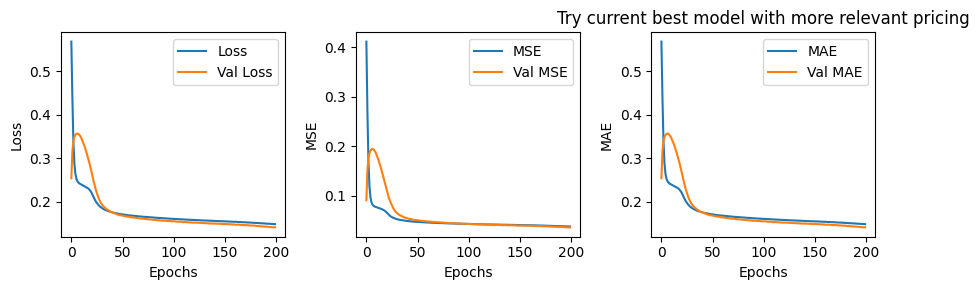

In [ ]:
plot_history(history, save=True)


### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

13/13 [==============================] - 6s 7ms/step


array([[0.5127208 ],
       [0.84990144],
       [0.78687394],
       ...,
       [0.40798843],
       [0.48654518],
       [0.65246576]], dtype=float32)

In [ ]:
test_labels = get_label(test_dataset)
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

,predicted,real,error
0,0.512721,0.236462,0.276258
1,0.849901,0.236462,0.613439
2,0.786874,0.836462,0.049588
3,0.926467,0.636462,0.290005
4,0.412648,1.000000,0.587352
...,...,...,...
24658,0.509629,0.436462,0.073167
24659,0.970558,1.000000,0.029442
24660,0.407988,0.636462,0.228474
24661,0.486545,0.836462,0.349917


In [ ]:
compare_test[compare_test["error"] > 1e-1]

,predicted,real,error
0,0.512721,0.236462,0.276258
1,0.849901,0.236462,0.613439
3,0.926467,0.636462,0.290005
4,0.412648,1.000000,0.587352
7,0.520166,0.636462,0.116296
...,...,...,...
24656,0.694037,0.236462,0.457575
24657,0.299770,0.436462,0.136693
24660,0.407988,0.636462,0.228474
24661,0.486545,0.836462,0.349917


In [ ]:
compare_test["error"].mean()

0.28912680779390915

## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-smote-simple\assets


INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-smote-simple\assets


In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/keras/recommender-smote-simple\assets


INFO:tensorflow:Assets written to: log/model/keras/recommender-smote-simple\assets


In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    # "data_distribution": {
    #     "positive": POSITIVE_SIZE,
    #     "negative": NEGATIVE_SIZE,
    #     "training_pos": TRAIN_POS_SIZE,
    #     "training_neg": TRAIN_NEG_SIZE,
    # },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 25)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 24)]         0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           23104       ['inf_feature[0][0]']            
                                                                                                  
 sequential_3 (Sequential)      (None, 64)           22848       ['own_feature[0][0]']            
                                                                                            

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()